# Week 5 - Neural Network Learning

We'll go back to the data from the pervious assignment where we applied a neural network to perform hand-written digit recognition.

We'll first implement the neural network cost function and forward propagation using the predetermined weights. Later, we'll implement backward propagation to learn the parameters after only providing an initial guess.

## Loading a Visualizing the Data

Let's first load the data.

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

# Set the data path
dataDir = "./assignment/ex4/"
dataFile = "ex4data1.mat"
dataPath = dataDir+dataFile

# Load the data
data = loadmat(dataPath)
X = data['X']
y = data['y']

# Set the weights path
weightsFile = "ex4weights.mat"
weightsPath = dataDir+weightsFile

# Load the weights
weights = loadmat(weightsPath)
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

# As an artifact of MATLAB, reset 10 to 0 for output and the parameter that provides the output
y[y==10] = 0
Theta2 = np.roll(Theta2, 1, axis=0)

# Get array sizes
m,n = X.shape

# Now unroll the parameters
nnParameters = np.concatenate([Theta1.ravel(),Theta2.ravel()])

# Set the y output as a matrix such that, for example, y = 2 becomes y = [0 0 1 0 0 0 0 0 0 0]
encoder = OneHotEncoder(sparse=False)
yMatrix = encoder.fit_transform(y)

# Set parameters used for the NN
inputLayerSize  = 400  # 20x20 Input Images of Digits
hiddenLayerSize = 25   # 25 hidden units
nLabels = 10           # 10 labels, from 0 to 9

Now let's create a function to display the images.

In [2]:
def display_data(X, example_width=None, figsize=(20,20)):
    
    """Displays 2D data stored in X in a nice grid"""
    
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    # Set the single sample display size
    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    
    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

And now let's display a sample of the data

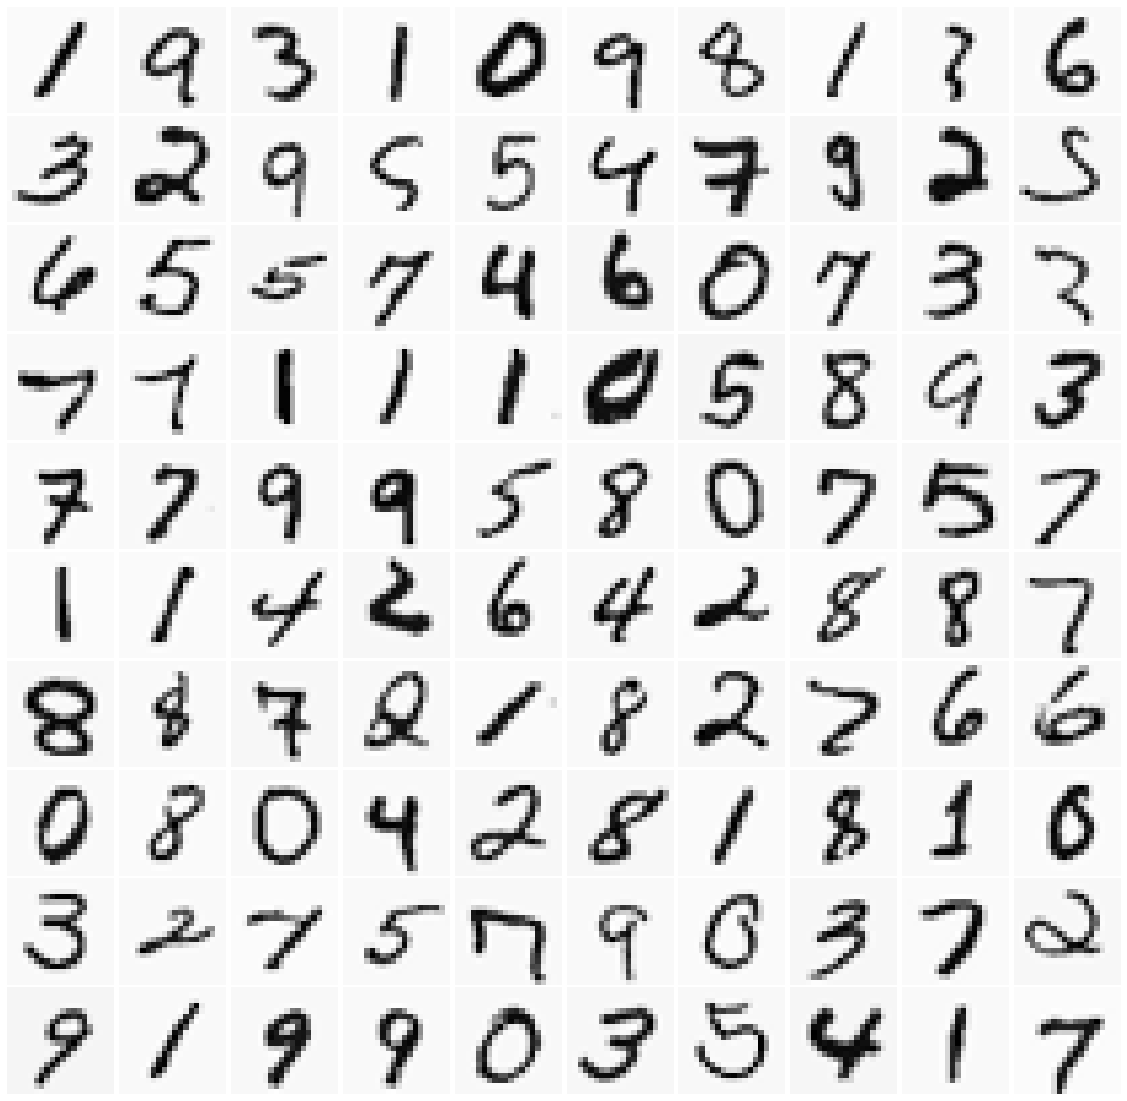

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
display_data(sel)

## Model Representation

The neural network architecture is shown in the following figure.

![Neural network representation](./images/neural_network.png "Neural network representation")

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 by 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1).

We have been provided with a set of network parameters already trained by us. These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

## Feedforward and Cost Function

Now we need to implement the cost function for the NN. Recall that the cost funtion is

$$ 
\begin{align}
J(\Theta) = & - \frac{1}{m} \Big[ \sum_{i=1}^m \sum_{k=1}^K
               y_k^{(i)} \log \big( (h_\Theta (x^{(i)}))_k \big) + 
               (1-y_k^{(i)}) \log \big( 1 - (h_\Theta (x^{(i)}))_k \big)
               \Big] \\
               & + \frac{\lambda}{2 m} \sum_{l=1}^{L-1} \sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} 
               \big( \Theta_{j,i}^{(l)} \big)^2
\end{align} 
\\ 
\\
y, h_\Theta (x) \in \mathbb{R}^K, (h_\Theta(x))_i := i\text{th output}
$$

Let's now create functions to perform the forward propagation and cost function.

In [4]:
def sigmoid(z):
    
    """Calulate the sigmoid function"""
    
    return 1 / (1 + np.exp(-z))

def forward_propagate(X,Theta1,Theta2):
    
    """Perform forward propagation on our NN"""
    
    # Get the number of samples from the X array
    m = X.shape[0]
    
    # Calculate the forward propagation
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * Theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * Theta2.T
    a3 = sigmoid(z3)
    
    return a1, z2, a2, z3, a3
    
def cost_function(nnParameters,inputLayerSize,hiddenLayerSize,nLabels,X,yMatrix,regCoeff=0):
    
    """Calculate the cost function of our NN"""
    
    # Get number of samples from X
    m = X.shape[0]
    
    # Set values as as matrices
    X = np.matrix(X)
    yMatrix = np.matrix(yMatrix)
    
    # Reshape the parameter array into parameter matrices for each layer
    Theta1 = np.matrix(np.reshape(nnParameters[:hiddenLayerSize*(inputLayerSize+1)], \
                                  (hiddenLayerSize, (inputLayerSize+1))))
    Theta2 = np.matrix(np.reshape(nnParameters[hiddenLayerSize*(inputLayerSize+1):], \
                                  (nLabels,(hiddenLayerSize+1))))
    
    # Run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X,Theta1,Theta2)
    
    # Compute the cost
    J = 0
    for i in range(m):
        J += (-yMatrix[i,:]*np.log(h[i,:]).T)-((1-yMatrix[i,:])*np.log(1-h[i,:]).T)
    
    # Scale by number of training samples
    J = J / m
    
    # Include regularization
    J += (float(regCoeff) / (2 * m)) * (np.sum(np.power(Theta1[:,1:], 2)) + \
                                        np.sum(np.power(Theta2[:,1:], 2)))
    
    return J.item()

## Backpropagation

Now, we can actually set up the backpropagation algorithm to set up our gradients used to minimize the cost function.

In [5]:
def sigmoid_gradient(z):
    
    """Calculate the gradient of the sigmoid function"""
    
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

def backprop(nnParameters,inputLayerSize,hiddenLayerSize,nLabels,X,yMatrix,regCoeff=0):

    # Reshape the parameter array into parameter matrices for each layer
    Theta1 = np.matrix(np.reshape(nnParameters[:hiddenLayerSize*(inputLayerSize+1)], \
                                  (hiddenLayerSize, (inputLayerSize+1))))
    Theta2 = np.matrix(np.reshape(nnParameters[hiddenLayerSize*(inputLayerSize+1):], \
                                  (nLabels,(hiddenLayerSize+1))))
    
    # Initializations
    Delta1 = np.zeros(Theta1.shape)  # (25, 401)
    Delta2 = np.zeros(Theta2.shape)  # (10, 26)
    
    # Run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X,Theta1,Theta2)
    
    # Run the cost function
    J = cost_function(nnParameters,inputLayerSize,hiddenLayerSize,nLabels,X,yMatrix,regCoeff)
    
    # Backpropagate to get gradients
    delta3 = h - yMatrix;
    delta2 = np.multiply(delta3*Theta2[:,1:],sigmoid_gradient(z2));
    Delta1 = delta2.T*a1;
    Delta2 = delta3.T*a2;
    Theta1Grad = Delta1/m;
    Theta2Grad = Delta2/m;

    # Add regularization
    Theta1[:,1] = 0;
    Theta1Grad = Theta1Grad + (regCoeff/m)*Theta1;
    Theta2[:,1] = 0;
    Theta2Grad = Theta2Grad + (regCoeff/m)*Theta2;
        
    # Unravel the gradient matrices into a single array
    grad = np.concatenate((Theta1Grad.ravel(),Theta2Grad.ravel()),axis=1)
    
    return J, grad

## Random Initiation of Parameters

We'll reset our initial parameters using random initialization to be between the range

$$ [ -\tau , \tau ], \tau = 0.12 $$

An effective strategy for choosing the value here is to base it on the number of units in the network. A good choice is 

$$ \tau \frac{\sqrt{6}}{\sqrt{L_\text{in} + L_\text{out}}} $$

where 

$$L_\text{in}  = s_l, L_\text{out} = s_{l+1}$$

are the number of units in the layers adjacent to 

$$\Theta^{(l)}$$

In [6]:
def random_initial_weights(L_in,L_out,tau=0.12):
    
    """Randomly initialize weights between +- tau"""
    
    # Initiate as zeros
    return np.random.rand(L_out, 1 + L_in) * 2 * tau - tau

In [7]:
# Compute initial parameters
initialTheta1 = random_initial_weights(inputLayerSize,hiddenLayerSize)
initialTheta2 = random_initial_weights(hiddenLayerSize,nLabels)

# Unroll parameters
initialNnParameters = np.concatenate([initialTheta1.ravel(), initialTheta2.ravel()])

## Minimizing the Cost Function

Finally, we pass these randomly initiated parameters along to a minimization routine to minimize our cost function. With our model output, we can evaluate the performance of the NN by comparing the output to the training data set.

In [8]:
# Minimize the cost function
fmin = optimize.minimize(fun=backprop,x0=initialNnParameters, \
                         args=(inputLayerSize,hiddenLayerSize,nLabels,X,yMatrix,1), \
                         method='TNC',jac=True,options={'maxiter':250})

# Reshape the output parameters of the minimized cost function
Theta1 = np.matrix(np.reshape(fmin.x[:hiddenLayerSize * (inputLayerSize + 1)], \
                              (hiddenLayerSize, (inputLayerSize + 1))))
Theta2 = np.matrix(np.reshape(fmin.x[hiddenLayerSize * (inputLayerSize + 1):], \
                              (nLabels, (hiddenLayerSize + 1))))

# Forward propagate again to get the hypothesis output
a1, z2, a2, z3, h = forward_propagate(X,Theta1,Theta2)

# Find the parameters where the probability is maximized
yPredicted = np.array(np.argmax(h,axis=1))

# Find the percent that matched the training sample from the NN
correct = [1 if a == b else 0 for (a, b) in zip(yPredicted, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('Accuracy = {0}%'.format(accuracy * 100))

Accuracy = 98.82%
